In [1]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

def downsample_float(img, block_size, offset):
    h, w, c = img.shape
    bh, bw = block_size
    oy, ox = offset

    nh = int(np.floor((h - oy) / bh))
    nw = int(np.floor((w - ox) / bw))

    low_res = np.zeros((nh, nw, c), dtype=np.float32)

    for i in range(nh):
        for j in range(nw):
            y0 = int(np.floor(oy + i * bh))
            y1 = int(np.floor(oy + (i + 1) * bh))
            x0 = int(np.floor(ox + j * bw))
            x1 = int(np.floor(ox + (j + 1) * bw))

            block = img[y0:y1, x0:x1]
            if block.size == 0:
                continue
            low_res[i, j] = block.mean(axis=(0, 1))

    crop_y0 = int(np.floor(oy))
    crop_x0 = int(np.floor(ox))
    crop_y1 = int(np.floor(oy + nh * bh))
    crop_x1 = int(np.floor(ox + nw * bw))

    return low_res, crop_y0, crop_x0, crop_y1, crop_x1

def upsample_float(low_res, block_size, img_shape, offset):
    h, w = img_shape
    bh, bw = block_size
    oy, ox = offset
    nh, nw, c = low_res.shape

    upsampled = np.zeros((h, w, c), dtype=np.float32)

    for i in range(nh):
        for j in range(nw):
            y0 = int(np.floor(oy + i * bh))
            y1 = int(np.floor(oy + (i + 1) * bh))
            x0 = int(np.floor(ox + j * bw))
            x1 = int(np.floor(ox + (j + 1) * bw))

            upsampled[y0:y1, x0:x1] = low_res[i, j]

    return upsampled

def compute_error(original, upsampled):
    diff = original - upsampled
    error = np.sqrt((diff ** 2).sum(axis=2))
    return error.mean()

def find_best_parameters(img, block_min: float = 8.0, block_max: float = 16.0, block_increment: float = 0.1):
    block_range = []
    blk = block_min
    while blk <= block_max:
        block_range.append(np.round(blk, 2))
        blk += block_increment

    max_offset = int(block_max)

    h, w, _ = img.shape
    best_error = float('inf')
    best_params = None

    for block_size in block_range:
        error_mat = np.zeros([max_offset + 1, max_offset + 1])
        print(f'Now testing block size: {block_size}')
        for oy in range(0, max_offset + 1):
            for ox in range(0, max_offset + 1):
                try:
                    low_res, crop_y0, crop_x0, crop_y1, crop_x1 = downsample_float(
                        img, (block_size, block_size), (oy, ox)
                    )
                    upsampled = upsample_float(
                        low_res, (block_size, block_size), (h, w), (oy, ox)
                    )
                    cropped_original = img[crop_y0:crop_y1, crop_x0:crop_x1]
                    cropped_upsampled = upsampled[crop_y0:crop_y1, crop_x0:crop_x1]

                    if cropped_original.shape != cropped_upsampled.shape:
                        continue

                    error = compute_error(
                        cropped_original.astype(np.float32),
                        cropped_upsampled.astype(np.float32)
                    )

                    if error < best_error:
                        best_error = error
                        best_params = (block_size, ox, oy)

                    error_mat[ox, oy] = error
                except Exception as e:
                    continue  # skip bad combos

        plt.figure()
        sns.heatmap(error_mat, vmin=error_mat.min(), vmax=error_mat.max(), cmap='viridis')
        plt.title(f'Error offset matrix for block_size: {block_size}')
        plt.xlabel('x offset (pixels)')
        plt.ylabel('y offset (pixels)')
        plt.show()

    return best_params, best_error


In [3]:
# --- Load Image ---
base_dir = os.path.abspath(os.getcwd())
file_name = 'ent_mini_boss_1024px.png'
input_path = os.path.join(base_dir, 'projects', 'castle', file_name)
img_rgba = Image.open(input_path).convert("RGBA")
img_data = np.array(img_rgba)


Now testing block size: 10.68


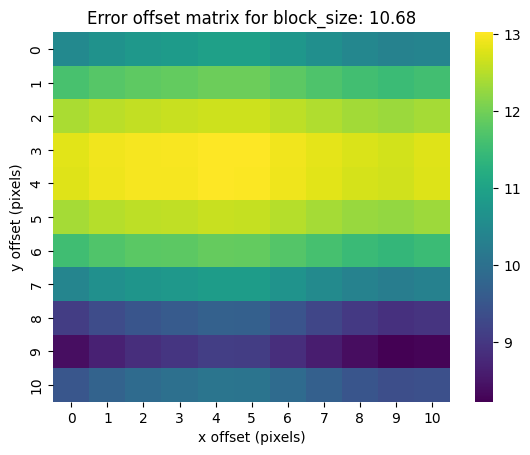

Now testing block size: 10.69


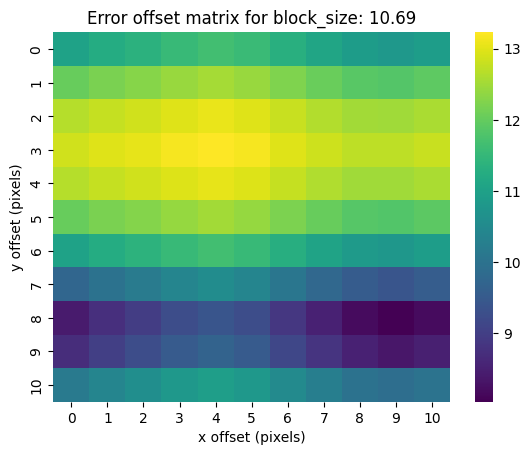

Now testing block size: 10.7


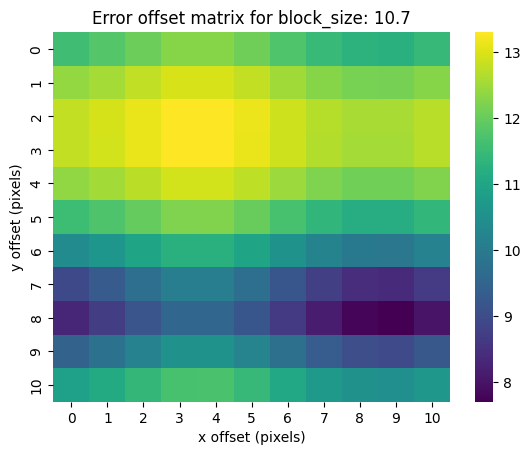

Now testing block size: 10.71


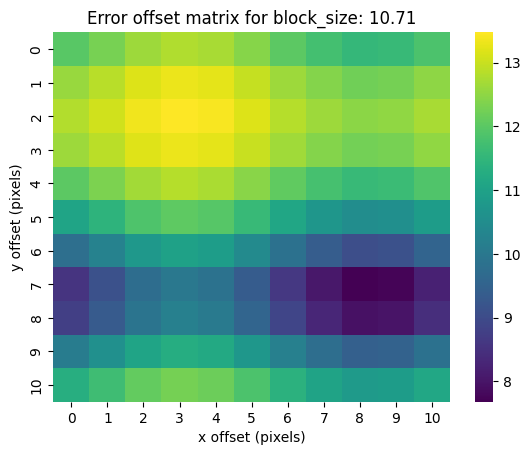

Now testing block size: 10.72


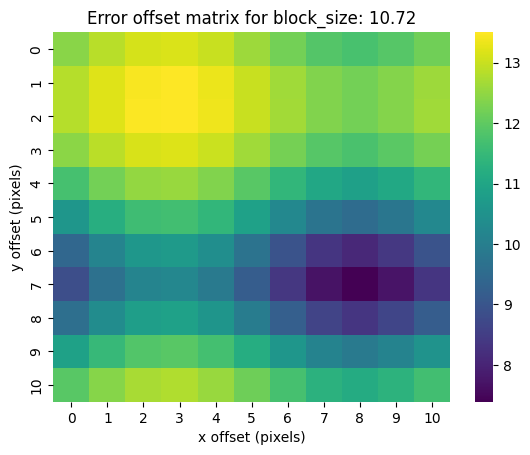

Now testing block size: 10.73


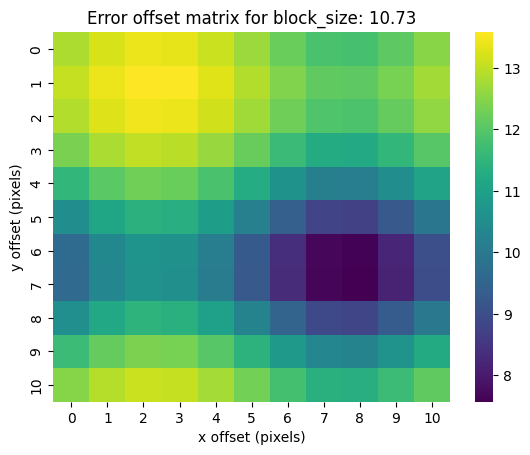

Now testing block size: 10.74


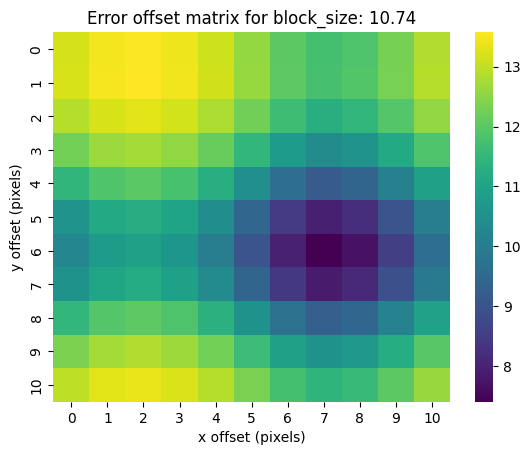

Now testing block size: 10.75


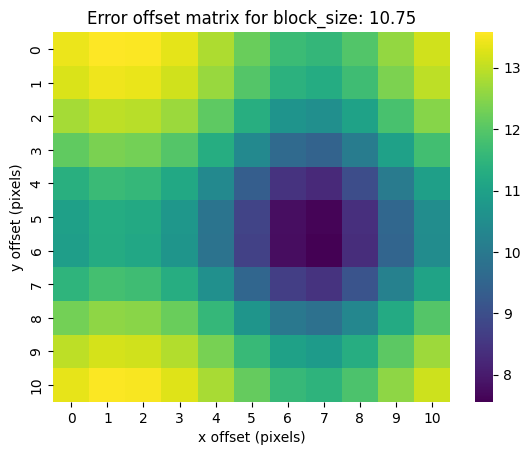

Best block size, x_offset, y_offset: (10.72, 7, 8), Error: 7.39
CPU times: total: 3min 57s
Wall time: 3min 57s


In [6]:
%%time

# manually set params after inspecting approximate block size from image
block_increment = 0.01  # 0.1 is a good starter for most situations
block_min = 10.68  # 6 is a good starter for most situations
block_max = 10.75  # 14 is a good starter for most situations

# --- Find best parameters ---  # NOTE: this takes about ~30 s per block_size for a 1024x1024 image
best_params, best_error = find_best_parameters(img_data, block_min, block_max, block_increment)
print(f"Best block size, x_offset, y_offset: {best_params}, Error: {best_error:.2f}")

In [5]:
# ent mini boss block_size was 10.7 --> 1024/10.7 = ~96

In [ ]:
# Best block size, x_offset, y_offset: (10.72, 7, 8), Error: 7.39

In [7]:
1024/10.72

95.52238805970148